In [36]:
import geopandas as gpd
import os
import pandas as pd
from shapely import wkt
from shapely.geometry import  Point
# import time
import matplotlib.pyplot as plt
# import geodatasets
import warnings
import calendar

states = ['OR','CA','AZ','TN','MT','WA','NM','WI','CO','WV','ID','VA','NV','NY','PA','AR','ME']
deadzone_pct_threshold = 0.1 # if 'Whitespace Area' / 'County Area' is greater than this; it is considered deadzone 
max_distance = .02 # from testing; max distance between a station and closest deadzone highway for it be considered 

[See](https://www.fhwa.dot.gov/policyinformation/tmguide/2022_TMG_Final_Report.pdf) section 4.2 for table value formats; Also [see](https://github.com/policyinfo/TMAS-Traffic-Volume-Data-Rearrangement-Tool/tree/main/PyRearrangeVolumeData)


In [37]:
path = r"C:\Users\SurajShourie(BBDOAtl\Downloads\2022_station_data\2022_station_data"
state = "OR"
path = f"{path}\\{state}_2022 (TMAS).STA"
df_station = pd.read_csv(path, delimiter="|")

In [38]:
def get_station_df(states):
    root_path = r"\\nvf02na.addomain.org\SASATL\AT&T\AT&T Network Strategy\Satellite\converted"
    qwe = []
    for state in states:
        # AK_2022 (TMAS).csv
        path = f"{root_path}\\{state}_2022 (TMAS).csv"
        df_station = pd.read_csv(path, delimiter="|")
        qwe.append(df_station)
    return pd.concat(qwe)

##### Use Yue's code to get deadzone highways

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

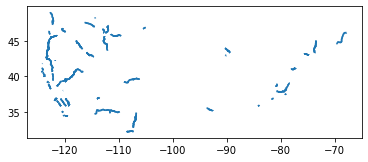

In [163]:
# from Yue's geomapping.py
path_map = r'\\npf01atl.addomain.org\Agency\Research\Team Work\Yue\ATT\satellite\GeoMap'
path_out = r'\\npf01atl.addomain.org\Agency\Research\Team Work\Yue\ATT\satellite\output'

df_hw = gpd.read_file('/'.join([path_map, 'tl_2021_us_primaryroads', 'tl_2021_us_primaryroads.shp']))
df_county = gpd.read_file('/'.join([path_map, 'UScounties', 'UScounties.shp']))
df_deadzone = pd.read_csv('/'.join([path_map, 'ATT_deadzone.csv']))

df_deadzone['pct'] = df_deadzone['Whitespace AreaSqMi'] / df_deadzone['County AreaSqMi']
df_deadzone = df_deadzone[df_deadzone['pct'] > deadzone_pct_threshold]

df_county['FIPS_num'] = df_county['FIPS'].apply(lambda f: int(f))
df_county_filtered = df_county[df_county['FIPS_num'].isin(df_deadzone['FIPS'])]

df_hw = df_hw.to_crs(df_county.crs)
dz_highway = gpd.sjoin(df_hw, df_county_filtered, how="inner", op="intersects")

dz_highway.plot()

#### Testing nearest highway for each station code

In [40]:
df_station = get_station_df(states)
# lot of unnecessary data here; clean it
# df_station['Cleaned_Signed_Route']  = df_station["Posted_Signed_Route"].apply(lambda x: str(int(x.strip())) if x.strip().isdigit() else x.strip().lstrip('0')) 
x = df_station['Latitude'] / 1e6  
y = -df_station['Longitude'] / 1e6 # kind of hard-coded bcoz of bad data structure

In [133]:
# Read the US map shapefile # https://www2.census.gov/geo/tiger/GENZ2018/
# path = r"C:\Users\SurajShourie(BBDOAtl\Downloads\cb_2018_us_nation_5m\cb_2018_us_nation_5m.shp"
path = r"\\nvf02na.addomain.org\SASATL\AT&T\AT&T Network Strategy\Satellite\Extra_files\cb_2018_us_state_5m.shp"
path = r"\\nvf02na.addomain.org\SASATL\AT&T\AT&T Network Strategy\Satellite\Extra_files\cb_2018_us_state_5m\cb_2018_us_state_5m.shp"
us_map = gpd.read_file(path)

# Create a DataFrame with the lat and lng values
geometry = [Point(xy) for xy in zip(y,x)]
df = gpd.GeoDataFrame(df_station, geometry=geometry, crs='EPSG:4326')

# combine with 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    temp = df.sjoin_nearest(dz_highway.drop('index_right', axis=1), distance_col="dist_", max_distance=max_distance)
temp = temp.drop_duplicates(subset = "State_Code")
# temp[['State_Code','Station_Id', 'FULLNAME', 'NAME', 'STATE_NAME', "dist_"]]
temp = temp.rename(columns = {'FULLNAME': 'Closest_Highway'})
df = temp.copy()
del temp
print(df.shape[0])

371


#### Get traffic Vol data for the filtered stations

In [66]:
station_codes = df['State_Code'].unique() # 'State_code' is a misnomer in the raw files
station_codes = [int(x) for x in station_codes if isinstance(x, int) or x.isdigit()] # convert to int and keep only integers

In [94]:
def get_vol_data(station_codes, use_cache=True, to_cache = True):
    if use_cache:
        path = r"\\nvf02na.addomain.org\SASATL\AT&T\AT&T Network Strategy\Satellite\Extra_files\daily_vol_selected.csv"
        try:
            df_vol = pd.read_csv(path)
        except:
            print("Data not cached. Check the path or set `use_cache=False`")
            
    else:
        print("Calculating.... will take around 20 mins... Read from cache if available")
        root_path = r"\\nvf02na.addomain.org\SASATL\AT&T\AT&T Network Strategy\Satellite\converted"
        months = calendar.month_abbr[1:]
        months = [x.upper() for x in months]
        qwe2 = []
        for month in months:
            print(month)
            qwe = []
            for state in states:
                path = f"{root_path}\\{state}_{month}_2022 (TMAS).VOL"
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    df_vol = pd.read_csv(path)
                qwe.append(df_vol)
            df_vol = pd.concat(qwe)
            df_vol = df_vol[df_vol['Station_Id'].isin(station_codes)]
            df_vol = df_vol.groupby(['Year_Record', 'Month_Record','Station_Id' ,'Day_Record'])['Hour_Volume'].sum().reset_index().rename(columns= {'Hour_Volume':"Daily_Volume"})
            qwe2.append(df_vol)
        df_vol = pd.concat(qwe2)
        
        if to_cache:
            path = r"\\nvf02na.addomain.org\SASATL\AT&T\AT&T Network Strategy\Satellite\Extra_files\daily_vol_selected.csv"
            df_vol.to_csv(path)
    return df_vol

In [ ]:
df_vol = get_vol_data(station_codes, use_cache=True, to_cache = True)

Merge with station data (need to clean data first) and get volume per station

In [132]:
df2 = df_vol.groupby(['Station_Id']).agg({'Daily_Volume': ['mean', 'max', 'min']})
df2 = df2.droplevel(0, axis=1).reset_index()
cols = ['mean', 'max', 'min']
for col in cols:
    df2[col] = df2[col].round(0)
dict_ = {x: "Daily_Volume_" + x for x in cols}
df2 = df2.rename(columns= dict_)

In [134]:
# station_codes = [int(x) for x in station_codes if isinstance(x, int) or x.isdigit()] # convert to int and keep only integers
# df['State_Code2'] = df
df['Clean_State_Code'] = df['State_Code'].apply(lambda x: int(x) if isinstance(x, int) or x.isdigit() else x)
df = df[df['Clean_State_Code'].isin(station_codes)]
df_plot = df.merge(df2, left_on = "Clean_State_Code", right_on = "Station_Id")

Merge with highway data and get average daily volume per highway

In [165]:
cols_ = ['FIPS_num','Station_Id_y','Daily_Volume_mean', 'Daily_Volume_max', 'Daily_Volume_min']
df3 = df_plot[cols_].groupby(['FIPS_num'])['Daily_Volume_mean'].mean().reset_index()
df3['Daily_Volume_mean'] = df3['Daily_Volume_mean'].round(0)
dz_highway = dz_highway.merge(df3, on="FIPS_num")

#### Static Plot

(-60.0, -140.0)

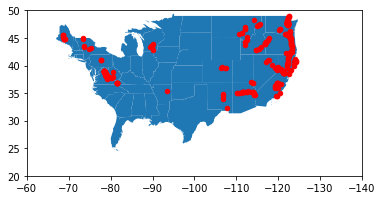

In [9]:
# Plot the DataFrame on the US map
fig, ax = plt.subplots()
# na.plot(ax=ax)
us_map.plot( ax=ax)
df.plot(ax = ax, marker = 'o', color='red', markersize = 20)
ax.set_ylim(20, 50)
ax.set_xlim(-60, -140)
# set latitude lines as major axis ticks
# ax.set_yticks([23, 30, 41], minor=False)
# ax.yaxis.grid(True, which='major')
# us_map.plot(df, marker="o", color="red")

#### Interactive Plot

In [166]:
import folium
m = us_map.explore(tooltip=False, 
    popup='NAME', 
    color='lightblue', 
    zoom_start = 3.5, location=(38, -95) # starting location for the map
)
df_plot.explore(m=m, 
    color='red', 
    tooltip = ['Station_Id_y', 'Closest_Highway', 'Daily_Volume_mean','Daily_Volume_max', 'Daily_Volume_min'], # the columns that will show up on hovering ['Posted_Signed_Route', 'State_Code','dist_']
    #    marker_type = 'marker', # other option is circle
    marker_kwds=dict(radius=3, fill=True),  # make marker radius 10px with fill
)
dz_highway.explore(m=m, color ='green', tooltip= ['FULLNAME', 'NAME', 'Daily_Volume_mean'],)
folium.TileLayer("Stamen Toner", show=True).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map

In [167]:
m.save('map.html')